# Example code to use model_utilities for biomass and carbon data cleaning and chapman-richards curve fitting

To do: 
- show wood density in action
- figure out where to put the ipcc csv so people can access

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from model_utilities import forest_mensuration
from model_utilities import dataset_builder
from model_utilities import ipcc_tier_1
from model_utilities.curve_fitting import curve_fitting
from model_utilities.curve_fitting import curve_formulas 

from model_utilities.dataset_builder import getNearbyMatureForestPercentiles
from model_utilities.dataset_builder import getWalkerValues

from model_utilities.visualization import plotting_ensemble
from model_utilities.visualization import plotting_maxs

In [2]:
from model_utilities.curve_fitting import curve_fitting

# Illustrate curve fit with (bounded) free p parameter

In [3]:
test_df = pd.DataFrame({'age': [4,10,1,13,26],
                       'agb_t_ha':[11.39,16.61,0.002663,9.1976,37.773707],
                       'source':['Ochoa Cuya et al. 2013','Alban et al. 2002','Alban et al. 2006',
                                'Llanos Aguilar et al. 2010','Llanos Aguilar et al. 2010'],
                        'species':['Caesalpinia spinosa','Prosopis pallida','Prosopis pallida',
                                  np.nan, np.nan]
                       })
test_df['bgb_t_ha'] = np.nan
test_df['agb_bgb_t_ha'] = np.nan

test_df

,age,agb_t_ha,source,species,bgb_t_ha,agb_bgb_t_ha
0,4,11.390000,Ochoa Cuya et al. 2013,Caesalpinia spinosa,NaN,NaN
1,10,16.610000,Alban et al. 2002,Prosopis pallida,NaN,NaN
2,1,0.002663,Alban et al. 2006,Prosopis pallida,NaN,NaN
3,13,9.197600,Llanos Aguilar et al. 2010,NaN,NaN,NaN
4,26,37.773707,Llanos Aguilar et al. 2010,NaN,NaN,NaN


In [4]:
# root-shoot values based on tropical dry forest
rs_break = 125
rs_young = 0.334
rs_old = 0.379

In [5]:
from model_utilities.forest_mensuration import clean_biomass_data

In [6]:
clean_df = forest_mensuration.clean_biomass_data(test_df,
                                            'biomass',
                                            rs_break=rs_break, 
                                            rs_young=rs_young, 
                                            rs_old=rs_old)
clean_df

,age,agb_t_ha,source,species,bgb_t_ha,agb_bgb_t_ha,agb_tCO2e_ha,bgb_tCO2e_ha,agb_bgb_tCO2e_ha
0,4,11.390000,Ochoa Cuya et al. 2013,Caesalpinia spinosa,3.804260,15.194260,19.628767,6.556008,26.184775
1,10,16.610000,Alban et al. 2002,Prosopis pallida,5.547740,22.157740,28.624567,9.560605,38.185172
2,1,0.002663,Alban et al. 2006,Prosopis pallida,0.000889,0.003552,0.004589,0.001533,0.006122
3,13,9.197600,Llanos Aguilar et al. 2010,NaN,3.071998,12.269598,15.850531,5.294077,21.144608
4,26,37.773707,Llanos Aguilar et al. 2010,NaN,12.616418,50.390125,65.096688,21.742294,86.838982


Add IPCC points to literature data

In [7]:
from model_utilities import ipcc_tier_1

In [8]:
ipcc_natural = ipcc_tier_1.PredictIPCC(polygonData=None,
            ecozone='tropical dry forest',
            continent='south america',
            forest_type='natural',
            yearStart = 0,
            yearEnd = 30)

ipcc_natural_mid = ipcc_natural['predictions']['natural']['biomass']

ipcc_time = np.arange(0, len(ipcc_natural_mid), 1)

ipcc_plantation = ipcc_tier_1.PredictIPCC(polygonData=None,
            ecozone='tropical dry forest',
            continent='south america',
            forest_type='other broadleaf',
            yearStart = 0,
            yearEnd = 30)

ipcc_plantation_mid = ipcc_plantation['predictions']['other broadleaf']['biomass']



# take mean of natural and other broadleaf plantation
ipcc_pts = np.mean([ipcc_natural_mid[[10,20,30]], 
                    ipcc_plantation_mid[[10,20,30]]
                   ], axis=0)
ipcc_pts = pd.DataFrame({'age':[10,20,30],
                       'agb_bgb_tCO2e_ha':ipcc_pts,
                        'source':['ipcc','ipcc','ipcc']})



Combine literature data with IPCC points

In [9]:
# merge literature data with IPCC points
data_il = pd.concat([clean_df, ipcc_pts])
data_il.reset_index(inplace=True, drop=True)
data_il

,age,agb_t_ha,source,species,bgb_t_ha,agb_bgb_t_ha,agb_tCO2e_ha,bgb_tCO2e_ha,agb_bgb_tCO2e_ha
0,4,11.390000,Ochoa Cuya et al. 2013,Caesalpinia spinosa,3.804260,15.194260,19.628767,6.556008,26.184775
1,10,16.610000,Alban et al. 2002,Prosopis pallida,5.547740,22.157740,28.624567,9.560605,38.185172
2,1,0.002663,Alban et al. 2006,Prosopis pallida,0.000889,0.003552,0.004589,0.001533,0.006122
3,13,9.197600,Llanos Aguilar et al. 2010,NaN,3.071998,12.269598,15.850531,5.294077,21.144608
4,26,37.773707,Llanos Aguilar et al. 2010,NaN,12.616418,50.390125,65.096688,21.742294,86.838982
5,10,NaN,ipcc,NaN,NaN,NaN,NaN,NaN,105.760000
6,20,NaN,ipcc,NaN,NaN,NaN,NaN,NaN,105.760000
7,30,NaN,ipcc,NaN,NaN,NaN,NaN,NaN,124.115000


Initialize GrowthCurveFit object with growth data

In [10]:
growth_curve_fit = curve_fitting.GrowthCurveFit(growth_df=data_il)

Create artificial array of maximum biomasses

In [11]:
max_biomass = pd.DataFrame({
    'Source':['Some mature biomass resource', 'Some mature biomass resource', 'Some mature biomass resource',
             'Second mature biomass','Second mature biomass','Second mature biomass'],
    'Detail':['p70', 'p80', 'p90','p70','p80','p90'],
    'agb_bgb_tCO2e_ha':[358.01, 385.92, 426.11, 362.34, 384.30, 409.92]
})

max_biomass

,Source,Detail,agb_bgb_tCO2e_ha
0,Some mature biomass resource,p70,358.01
1,Some mature biomass resource,p80,385.92
2,Some mature biomass resource,p90,426.11
3,Second mature biomass,p70,362.34
4,Second mature biomass,p80,384.30
5,Second mature biomass,p90,409.92


Set the max_df variable in the class

In [12]:
growth_curve_fit.set_maxes(max_df=max_biomass)

Do a curve fit for each max biomass

In [13]:
growth_curve_fit.fit_curve(curve_formula='chapman_richards_set_ymax',
                           curve_fit_params=None,
                           set_params=None)

/Users/anikastaccone/Documents/earthshot/github_repos/model_utilities/model_utilities/curve_fitting/curve_formulas.py:22: RuntimeWarning: invalid value encountered in power
  y = x[: ,1] * np.power( (1 - np.exp(-k * x[: ,0])), p)


In [14]:
growth_curve_fit.params

[array([0.00860902, 0.76667047]),
 array([0.00761238, 0.76099021]),
 array([0.00648789, 0.75462254]),
 array([0.00844004, 0.76570522]),
 array([0.00766469, 0.76128751]),
 array([0.006904 , 0.7569702])]

In [15]:
growth_curve_fit.covars

[array([[8.77504055e-05, 3.70688396e-03],
        [3.70688396e-03, 1.62962712e-01]]),
 array([[7.31958518e-05, 3.32022512e-03],
        [3.32022512e-03, 1.56291754e-01]]),
 array([[5.78073109e-05, 2.88436370e-03],
        [2.88436370e-03, 1.48854208e-01]]),
 array([[8.52233664e-05, 3.64119624e-03],
        [3.64119624e-03, 1.61823939e-01]]),
 array([[7.39389360e-05, 3.34049805e-03],
        [3.34049805e-03, 1.56639906e-01]]),
 array([[6.33851386e-05, 3.04638475e-03],
        [3.04638475e-03, 1.51624102e-01]])]

Looks like it works; could be nice to have convenience functions to "get" these attributes. The next steps are a method to do the predictions (I guess these get stored in their own dataframe), Monte Carlo uncertainties (these are like predictions and may use the prediction function, just with other parameters... should results be stored in a dataframe and should they be all the ensemble members? I think so, yes), and then, in a separate module for plotting, a plotting function that can take the optimal estimates, and the MC ensembles, 

In [16]:
growth_curve_fit.predictions_with_monte_carlo(years_predict=100, n_mc=500)

/Users/anikastaccone/Documents/earthshot/github_repos/model_utilities/model_utilities/curve_fitting/curve_formulas.py:22: RuntimeWarning: invalid value encountered in power
  y = x[: ,1] * np.power( (1 - np.exp(-k * x[: ,0])), p)
/Users/anikastaccone/Documents/earthshot/github_repos/model_utilities/model_utilities/curve_fitting/curve_formulas.py:22: RuntimeWarning: divide by zero encountered in power
  y = x[: ,1] * np.power( (1 - np.exp(-k * x[: ,0])), p)
/Users/anikastaccone/Documents/earthshot/github_repos/model_utilities/model_utilities/curve_fitting/curve_formulas.py:22: RuntimeWarning: invalid value encountered in power
  y = x[: ,1] * np.power( (1 - np.exp(-k * x[: ,0])), p)
/Users/anikastaccone/Documents/earthshot/github_repos/model_utilities/model_utilities/curve_fitting/curve_formulas.py:22: RuntimeWarning: divide by zero encountered in power
  y = x[: ,1] * np.power( (1 - np.exp(-k * x[: ,0])), p)
/Users/anikastaccone/Documents/earthshot/github_repos/model_utilities/model_ut

In [17]:
growth_curve_fit.prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               100 non-null    int64  
 1   Some mature biomass resource_p70  100 non-null    float64
 2   Some mature biomass resource_p80  100 non-null    float64
 3   Some mature biomass resource_p90  100 non-null    float64
 4   Second mature biomass_p70         100 non-null    float64
 5   Second mature biomass_p80         100 non-null    float64
 6   Second mature biomass_p90         100 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 5.6 KB


In [18]:
growth_curve_fit.prediction_df

,Age,Some mature biomass resource_p70,Some mature biomass resource_p80,Some mature biomass resource_p90,Second mature biomass_p70,Second mature biomass_p80,Second mature biomass_p90
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,9.316503,9.399349,9.493432,9.330507,9.394988,9.458641
2,2,15.798418,15.882656,15.978126,15.812667,15.878226,15.942874
3,3,21.487677,21.561200,21.644523,21.500112,21.557333,21.613787
4,4,26.702398,26.760717,26.826901,26.712254,26.757648,26.802512
...,...,...,...,...,...,...,...
95,95,229.096719,232.836627,237.188767,229.723201,232.637602,235.560602
96,96,230.285388,234.102023,238.545823,230.924589,233.898867,236.883083
97,97,231.462027,235.355702,239.891621,232.113994,235.148397,238.194123
98,98,232.626786,236.597804,241.226289,233.291564,236.386331,239.493855


In [19]:
growth_curve_fit.monte_carlo_dfs.keys()

dict_keys(['Some mature biomass resource_p70', 'Some mature biomass resource_p80', 'Some mature biomass resource_p90', 'Second mature biomass_p70', 'Second mature biomass_p80', 'Second mature biomass_p90'])

In [20]:
growth_curve_fit.monte_carlo_dfs['Some mature biomass resource_p70'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 500 entries, sim_0 to sim_499
dtypes: float64(500)
memory usage: 390.8 KB


In [21]:
growth_curve_fit.monte_carlo_dfs['Some mature biomass resource_p70'].head()

,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,5.233473,18.491273,1.424166,NaN,12.218875,NaN,5.512291,6.196254,4.468165,3.341138,...,17.940810,1.797062,0.714674,5.542459,7.905968,11.702103,3.185454,8.422717,NaN,3.935587
2,9.809881,27.338830,3.674214,NaN,19.402148,NaN,10.826851,11.702602,8.704905,7.297631,...,28.258874,4.778132,2.430044,8.996483,13.265644,19.887986,6.839520,15.262710,NaN,8.023463
3,14.141065,34.343296,6.362509,NaN,25.405645,NaN,16.022181,16.934831,12.830383,11.480166,...,36.807440,8.403290,4.912710,11.938991,17.938817,27.070621,10.658660,21.559156,NaN,12.137097
4,18.306517,40.358723,9.358704,NaN,30.741646,NaN,21.115776,21.975105,16.869902,15.789565,...,44.353476,12.478658,8.028278,14.589767,22.207206,33.645877,14.568090,27.500734,NaN,16.248410


Get confidence interval around curve

In [22]:
ensemble_bounded = curve_fitting.ensemble_ci(growth_curve_fit)

number ensemble members removed:  -578


Plot the entire ensemble of curves

Number ensemble members filtered:  78 in  0
Number ensemble members filtered:  109 in  1
Number ensemble members filtered:  93 in  2
Number ensemble members filtered:  92 in  3
Number ensemble members filtered:  102 in  4
Number ensemble members filtered:  104 in  5


<module 'matplotlib.pyplot' from '/Users/anikastaccone/opt/anaconda3/envs/spatial-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

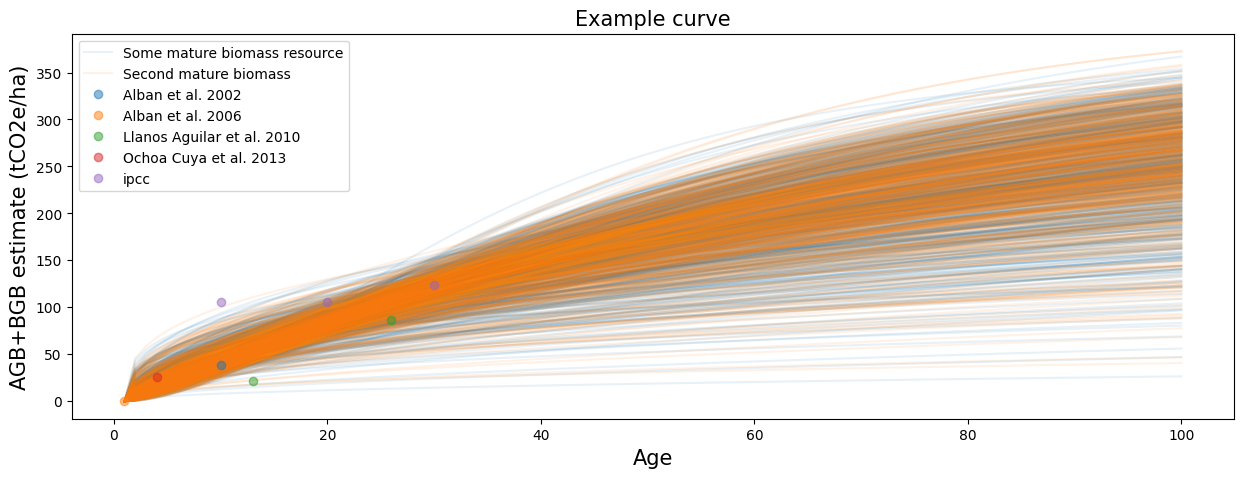

In [23]:
plotting_ensemble(growth_curve_fit, title='Example curve', nyears=100, frac_plot=0.5, plotdata=True)

Plot just the single curve for each maximum

<module 'matplotlib.pyplot' from '/Users/anikastaccone/opt/anaconda3/envs/spatial-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

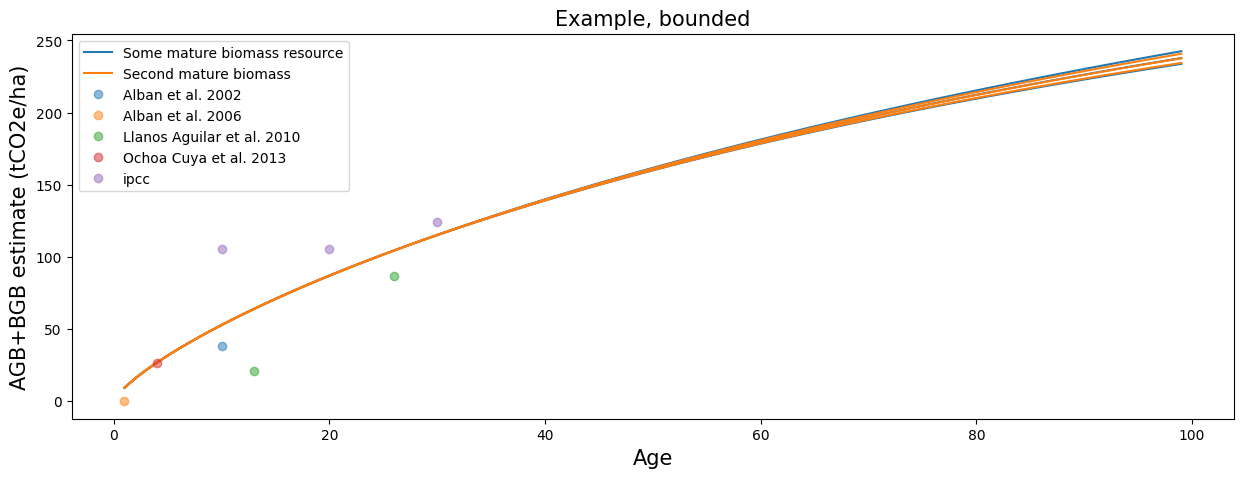

In [24]:
plotting_maxs(growth_curve_fit, 'Example, bounded', 100, True)

Extract an ensemble member that most closely matches the given percentile

In [25]:
mod_scenario = curve_fitting.extract_ensemble_member(growth_curve_fit, ensemble_bounded, 0.5)
mod_scenario

0       0.000000
1       5.894309
2      11.174348
3      16.209869
4      21.074223
         ...    
95    260.202658
96    261.616409
97    263.013738
98    264.394844
99    265.759926
Name: 2449, Length: 100, dtype: float64

Plot confidence interval

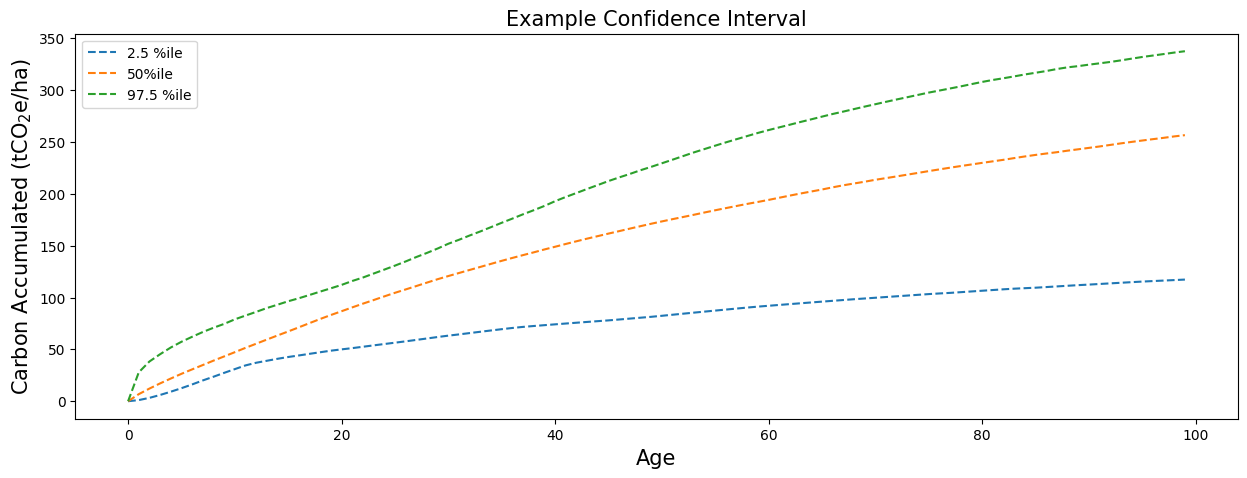

In [26]:
# confidence interval
fig, ax = plt.subplots(figsize=(15,5))

ensemble_bounded.plot(y=[0.025,0.5,0.975], x='Age', 
                          linestyle='--', ax=ax, label=['2.5 %ile','50%ile','97.5 %ile'])

ax.set_title('Example Confidence Interval', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Carbon Accumulated (tCO$_{2}$e/ha)', fontsize=15)

plt.show()

# With set p

In [27]:
growth_curve_fit_p = curve_fitting.GrowthCurveFit(growth_df=test_df)
growth_curve_fit_p.set_maxes(max_df=max_biomass)
growth_curve_fit_p.fit_curve(curve_formula='chapman_richards_set_ymax_and_p',
                           curve_fit_params=None,
                           set_params={'p':3})

In [28]:
growth_curve_fit_p.params

[array([0.03878837]),
 array([0.03716623]),
 array([0.03517951]),
 array([0.03852133]),
 array([0.03725434]),
 array([0.03593668])]

In [29]:
growth_curve_fit_p.covars

[array([[1.7531581e-05]]),
 array([[1.57010423e-05]]),
 array([[1.36447243e-05]]),
 array([[1.72204529e-05]]),
 array([[1.57969068e-05]]),
 array([[1.44050078e-05]])]

In [30]:
growth_curve_fit_p.predictions_with_monte_carlo(years_predict=100, n_mc=500)

In [31]:
growth_curve_fit_p.prediction_df

,Age,Some mature biomass resource_p70,Some mature biomass resource_p80,Some mature biomass resource_p90,Second mature biomass_p70,Second mature biomass_p80,Second mature biomass_p90
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.019716,0.018742,0.017601,0.019553,0.018793,0.018029
2,2,0.148895,0.141876,0.133633,0.147721,0.142251,0.136729
3,3,0.474562,0.453259,0.428161,0.471005,0.454397,0.437598
4,4,1.062705,1.017363,0.963776,1.055142,1.019789,0.983948
...,...,...,...,...,...,...,...
95,95,331.723029,353.001793,382.482655,335.069273,351.785216,370.766133
96,96,332.698779,354.168555,383.938643,336.074046,352.940649,372.103834
97,97,333.639209,355.295178,385.347801,337.042744,354.056219,373.397361
98,98,334.545531,356.382955,386.711515,337.976592,355.133215,374.648066


Number ensemble members filtered:  0 in  0
Number ensemble members filtered:  0 in  1
Number ensemble members filtered:  0 in  2
Number ensemble members filtered:  0 in  3
Number ensemble members filtered:  0 in  4
Number ensemble members filtered:  0 in  5


<module 'matplotlib.pyplot' from '/Users/anikastaccone/opt/anaconda3/envs/spatial-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

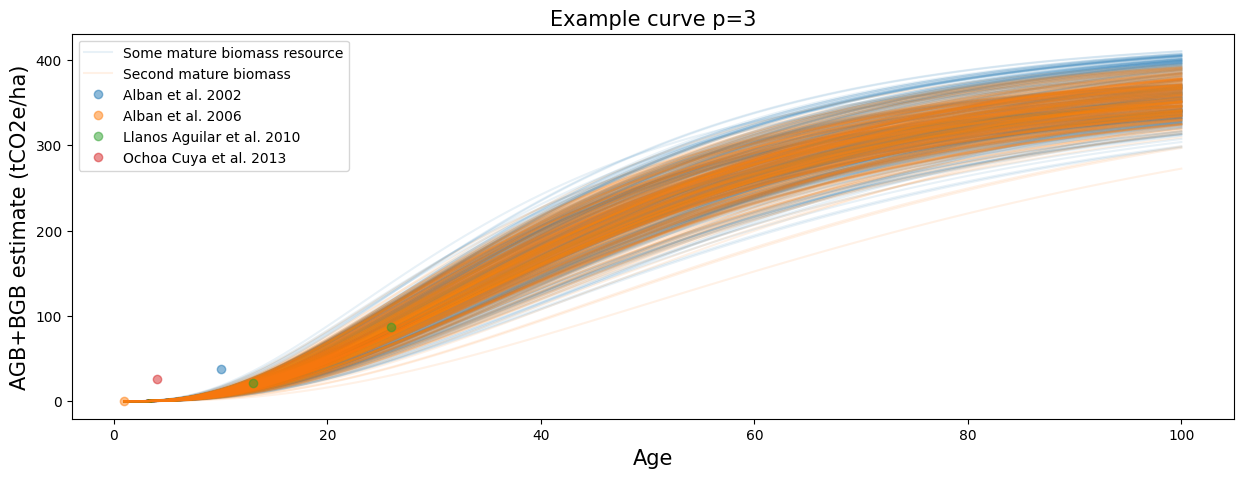

In [32]:
plotting_ensemble(growth_curve_fit_p, title='Example curve p=3', nyears=100, frac_plot=0.25, plotdata=True)